In [175]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import models, layers


In [176]:
IMAGE_SIZE = (256, 256)  # Set your desired size
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [177]:
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image, label

In [178]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'traffic_data',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # adjust label_mode as needed
)


Found 4170 files belonging to 58 classes.


In [179]:
class_names = dataset.class_names

# Print the class names
print("Class Names:", class_names)

Class Names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']


In [180]:
# Apply the preprocessing function to each image in the dataset
dataset = dataset.map(preprocess_image)

In [181]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 58), dtype=tf.float32, name=None))>

In [182]:
len(dataset)

131

In [183]:
131*32

4192

In [184]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy()) # every element we get is a tensor so we need to convert it to numpy.

(32, 256, 256, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [185]:
import numpy as np

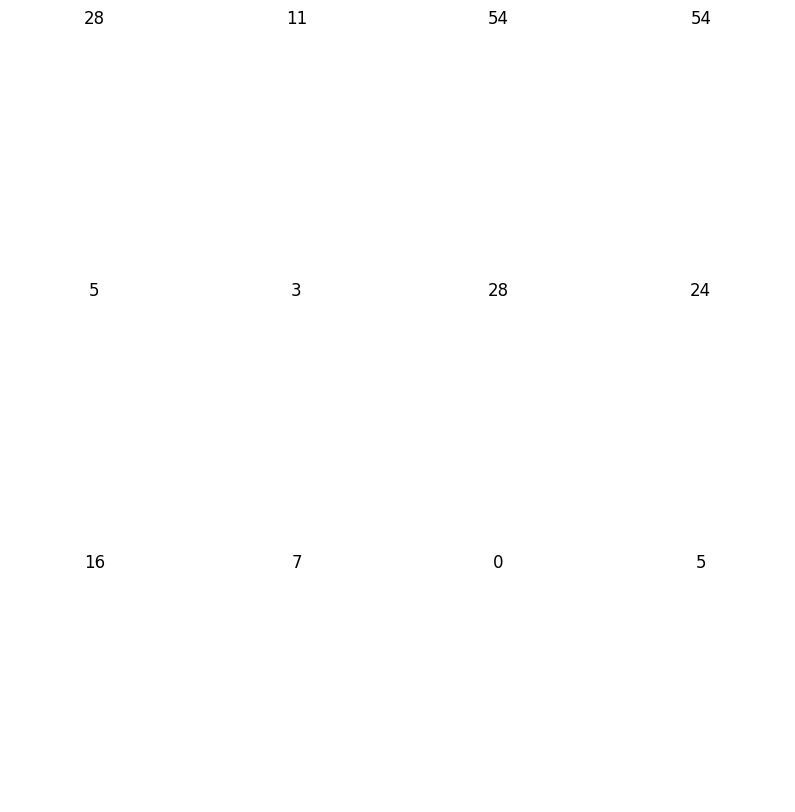

In [186]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
   for i in range(12):
       plt.subplot(3,4,i+1) # it should be between 1 and 12 not 0 and 12 when defining a subplot.
       plt.axis('off')
       label_index = np.argmax(label_batch[i].numpy())
       plt.title(class_names[label_index])

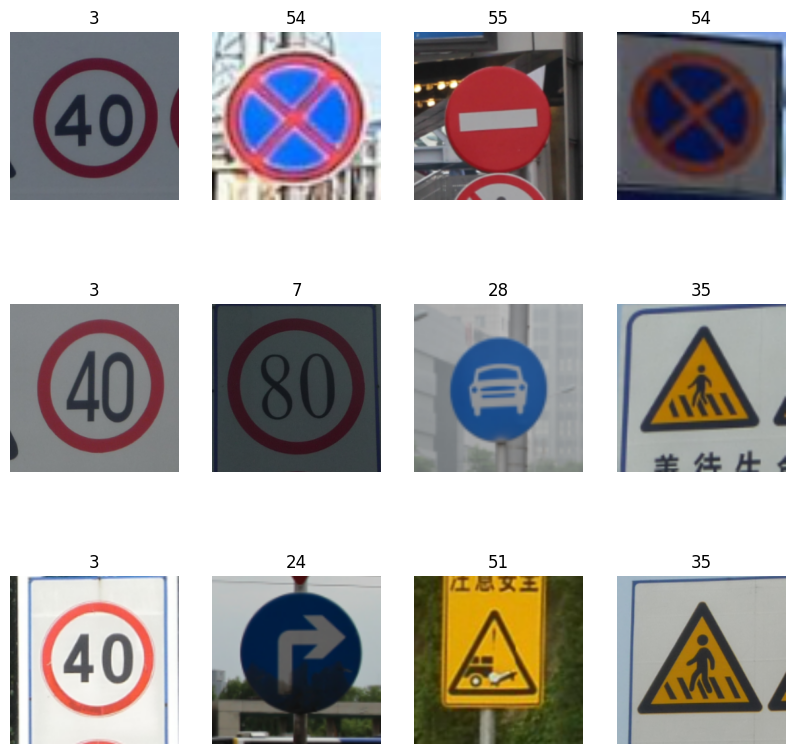

In [187]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
   for i in range(12):
       plt.subplot(3,4,i+1) # it should be between 1 and 12 not 0 and 12 when defining a subplot.
       plt.imshow(image_batch[i].numpy().astype('uint8')) # it expects 3d array. it was float so we convert it to integer
       plt.axis('off')
       label_index = np.argmax(label_batch[i].numpy())
       plt.title(class_names[label_index])